In [2]:
import os
import sys
import numpy as np
import pandas as pd
import pickle
import random
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import hinge_loss
from AEspeech import AEspeech
import pdb
from sklearn import metrics
from sklearn import svm, datasets
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import joblib

In [63]:
#load results for model type and speech representation type (aggregated and per utterance) as well as mfda scores

PATH=os.getcwd()

mod="CAE"
rep='wvlt'
aggResultsPath=PATH+"/pdSpanish/classResults/svm/"+mod+'_'+rep+'_aggResults.pkl'
aggResults=pd.read_pickle(aggResultsPath)
results_path=PATH+"/pdSpanish/classResults/svm/"+mod+'_'+rep+'Results.pkl'
results=pd.read_pickle(results_path)

mfda_path=PATH+"/pdSpanish/"
mfdas=pd.read_csv(mfda_path+"metadata-Spanish_All.csv")['M-FDA'].values
pd_mfdas=mfdas[0:50]
hc_mfdas=mfdas[50:]

In [57]:
num_itrs=max(aggResults['Data']['bin_class'].keys())+1
sdAggResults=np.zeros((100,num_itrs,aggResults['Data']['bin_class'][0][0].shape[0],aggResults['Data']['bin_class'][0][0].shape[1]))
avgAggResults={spk:{num[i]:[] for num in zip(range(50),range(50,100))} for i,spk in enumerate(['pd','hc'])}
# sdAggResults={spk:{num[i]:spk_sample_res for num in zip(range(50),range(50,100))} for i,spk in enumerate(['pd','hc'])}


for j in range(num_itrs):
    for i in range(100):
        sdAggResults[i,j,:,:]=aggResults['Data']['bin_class'][j][i]
        
        if j==0:
            if i<50:
                avgAggResults['pd'][i]=aggResults['Data']['bin_class'][j][i]*(1/num_itrs)
            else:
                avgAggResults['hc'][i]=aggResults['Data']['bin_class'][j][i]*(1/num_itrs)
        else:
            if i<50:
                avgAggResults['pd'][i]+=aggResults['Data']['bin_class'][j][i]*(1/num_itrs)
            else:
                avgAggResults['hc'][i]+=aggResults['Data']['bin_class'][j][i]*(1/num_itrs)

In [58]:
test_acc=0
y_score=np.zeros((100,2))
y_score_curr=y_score
y_test=np.zeros((100,2))
y_test_curr=y_test
UTTERS=['pataka','kakaka','pakata','papapa','petaka','tatata']
utter='tatata'
uIdx=UTTERS.index(utter)

max_acc=0
for thresh in range(-100,100):
    thresh=thresh/100
    test_acc=0
    for i in range(100):
        if i<50:
            y_score_curr[i,:]=np.median(avgAggResults['pd'][i][:,0]),np.median(avgAggResults['pd'][i][:,1])
            y_test_curr[i,:]=np.vstack((np.zeros(1),np.ones(1))).T
            spk_diff=y_score_curr[i,1]-y_score_curr[i,0]
            if spk_diff>thresh:
                test_acc+=1
        else:
            y_score_curr[i,:]=np.median(avgAggResults['hc'][i][:,0]),np.median(avgAggResults['hc'][i][:,1])
            y_test_curr[i,:]=np.vstack((np.ones(1),np.zeros(1))).T
            spk_diff=y_score_curr[i,1]-y_score_curr[i,0]
            if spk_diff<thresh:
                test_acc+=1
    
    if max_acc<test_acc/100:
        max_acc=test_acc/100
        opt_thresh=thresh
        y_score=y_score_curr
        y_test=y_test_curr
        

Text(0.5, 1.0, 'Variation of Estimator per Speaker (Over 3 Iterations)\nCAE, broadband')

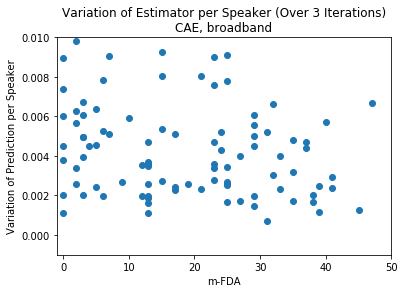

In [59]:
spk_avg_var=np.zeros(100)
for i in range(100):
    if i<50:
        spk_avg_var[i]=np.mean(np.var(sdAggResults[i],axis=0))
    else:
        spk_avg_var[i]=np.mean(np.var(sdAggResults[i],axis=0))
        
plt.scatter(mfdas,spk_avg_var)
plt.xlim([-1,50])
plt.ylim([-.001,.01])
plt.xlabel('m-FDA')
plt.ylabel('Variation of Prediction per Speaker')
plt.title('Variation of Estimator per Speaker (Over '+str(num_itrs)+' Iterations)\n'+mod+", "+rep)

Text(0.5, 1.0, 'Predicted Probability of Corect Classification v. m-FDA\nOverall Test Acc: 0.76 \nCAE, broadband')

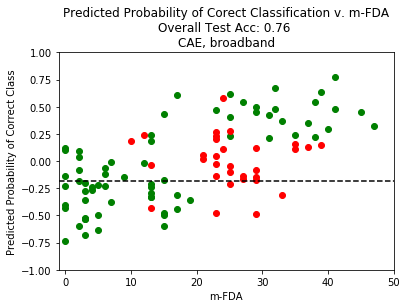

In [60]:
# """Plots predicted probability of correct class. (ostensibly, greater than 0.5 implies correct class.)"""
# correct_idx=np.where(np.concatenate((y_score[0:50,1],y_score[50:,0]))>.5)
# incorrect_idx=np.where(np.concatenate((y_score[0:50,1],y_score[50:,0]))<.5)
# plt.scatter(mfdas[correct_idx],np.concatenate((y_score[0:50,1],y_score[50:,0]))[correct_idx],c='g' )
# plt.scatter(mfdas[incorrect_idx],np.concatenate((y_score[0:50,1],y_score[50:,0]))[incorrect_idx],c='r' )
# plt.axhline(y=0.5, color='black', linestyle='--')
# plt.xlim([-1,50])
# plt.ylim([0,1])
# plt.xlabel('m-FDA')
# plt.ylabel('Predicted Probability of Correct Class')
# plt.title('Predicted Probability of Corect Classification v. m-FDA\nOverall Test Acc: '+str(max_acc)+' \n'+mod+", "+rep)

"""Plots difference between predicted class probs. and optimal threshold line"""
correct_idx=np.concatenate((np.where((y_score[0:50,0]-y_score[0:50,1])<opt_thresh)[0],np.where((y_score[50:,0]-y_score[50:,1])>opt_thresh)[0]+50))
incorrect_idx=np.concatenate((np.where((y_score[0:50,0]-y_score[0:50,1])>opt_thresh)[0],np.where((y_score[50:,0]-y_score[50:,1])<opt_thresh)[0]+50))
plt.scatter(mfdas[correct_idx],(y_score[:,1]-y_score[:,0])[correct_idx],c='g' )
plt.scatter(mfdas[incorrect_idx],(y_score[:,1]-y_score[:,0])[incorrect_idx],c='r' )
plt.axhline(y=opt_thresh, color='black', linestyle='--')
plt.xlim([-1,50])
plt.ylim([-1,1])
plt.xlabel('m-FDA')
plt.ylabel('Predicted Probability of Correct Class')
plt.title('Predicted Probability of Corect Classification v. m-FDA\nOverall Test Acc: '+str(max_acc)+' \n'+mod+", "+rep)

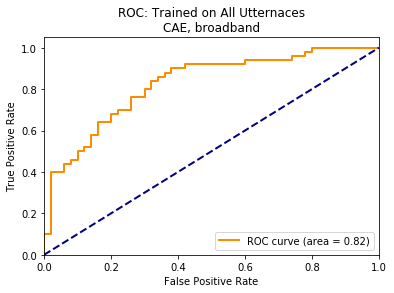

In [61]:
fpr=dict()
tpr=dict()
roc_auc=dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(np.array(y_test[:, i]), np.array(y_score[:, i]))
    roc_auc[i] = auc(fpr[i], tpr[i])

lw = 2
mgc=1
plt.plot(fpr[mgc], tpr[mgc], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[mgc])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: Trained on All Utternaces\n'+mod+", "+rep)
plt.legend(loc="lower right")

In [10]:
"""
Results where training/testing done independently per utterance.
"""
results

,pataka,kakaka,pakata,papapa,petaka,tatata
train_acc,0.7175,0.915,0.728333,0.849167,0.813333,0.905
test_acc,0.55,0.5,0.51,0.51,0.546667,0.57
bin_class,"{0: {20: [0.3551730683539006, 0.64482693164609...","{0: {4: [0.09524308182471006, 0.90475691817528...","{0: {49: [1.89481840529348e-07, 0.999999810518...","{0: {22: [0.12564854547427623, 0.8743514545257...","{0: {1: [0.41611749215789123, 0.58388250784210...","{0: {12: [0.5, 0.5], 78: [0.512857442381049, 0..."
class_report,{0: {0: ' precision recall f1...,{0: {0: ' precision recall f1...,{0: {0: ' precision recall f1...,{0: {0: ' precision recall f1...,{0: {0: ' precision recall f1...,{0: {0: ' precision recall f1...


In [54]:
# """
# ADD choice number of pcs (>90% cumultive variance) 
# """
# fig,ax=plt.subplots(2,3,figsize=(15,8))

# for uItr,utter in enumerate(UTTERS):
#     row_itr=np.mod(uItr,2)
#     col_itr=np.mod(uItr,3)
#     pc_data=pd.read_pickle(PATH+"/pdSpanish/classResults/svm/params/"+mod+'_'+utter+'_'+rep+'_pc.pkl')
#     x=max(np.where(pc_data.loc['pc_var']['pataka']<90)[0])
#     y=pc_data.loc['pc_var']['pataka'][x]
    
#     ax[row_itr][col_itr].plot(pc_data.loc['pc_var']['pataka'])
#     ax[row_itr][col_itr].vlines(x, 0, y, linestyle="dashed")
#     ax[row_itr][col_itr].hlines(y, 0, x, linestyle="dashed")
#     ax[row_itr][col_itr].set_title("Cumulative Explained Variance per PC\n Min. # of Components Cumulating >90%: "+str(x))
#     ax[row_itr][col_itr].set_xlabel("# components")
#     ax[row_itr][col_itr].set_ylabel("cumulative explained variance")
#     ax[row_itr][col_itr].set_xlim([-.5, 100])
#     ax[row_itr][col_itr].set_ylim([min(pc_data.loc['pc_var']['pataka']), 100.5])
    
# plt.tight_layout()

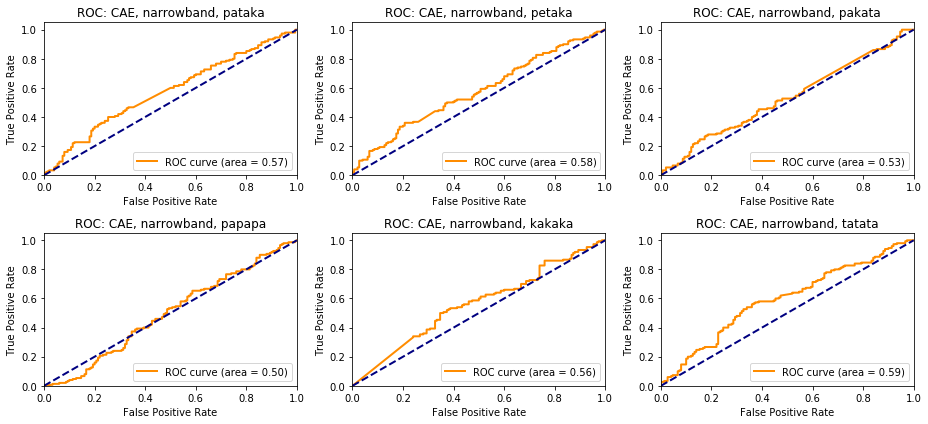

In [55]:
"""
Results reported per utterance.
"""
num_itrs=list(results['pataka']['bin_class'].keys())[-1]+1
y_scores=np.zeros((100*len(UTTERS)*num_itrs,2))
y_tests=np.zeros((100*len(UTTERS)*num_itrs,2))

                  
fig,ax=plt.subplots(2,3,figsize=(13, 6))
for uItr,utter in enumerate(UTTERS):
    y_score=np.zeros((100*num_itrs,2))
    y_test=np.zeros((100*num_itrs,2))

    for j in range(100):
        for i in range(num_itrs):
            y_score[i*100+j]+=results[utter]['bin_class'][i][j]
            if j<50:
                y_test[i*100+j,:]=np.vstack((np.zeros(1),np.ones(1))).T
            if j>=50:
                y_test[i*100+j,:]=np.vstack((np.ones(1),np.zeros(1))).T
    
    y_scores[uItr*100*num_itrs:(uItr+1)*100*num_itrs]=y_score
    y_tests[uItr*100*num_itrs:(uItr+1)*100*num_itrs]=y_test
    fpr=dict()
    tpr=dict()
    roc_auc=dict()
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    lw = 2
    mgc=1
    row_itr=np.mod(uItr,2)
    col_itr=np.mod(uItr,3)
    ax[row_itr][col_itr].plot(fpr[mgc], tpr[mgc], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[mgc])
    ax[row_itr][col_itr].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax[row_itr][col_itr].set_xlim([0.0, 1.0])
    ax[row_itr][col_itr].set_ylim([0.0, 1.05])
    ax[row_itr][col_itr].set_xlabel('False Positive Rate')
    ax[row_itr][col_itr].set_ylabel('True Positive Rate')
    ax[row_itr][col_itr].set_title('ROC: '+mod+", "+rep+", "+utter)
    ax[row_itr][col_itr].legend(loc="lower right")
#     plt.show()
plt.tight_layout()


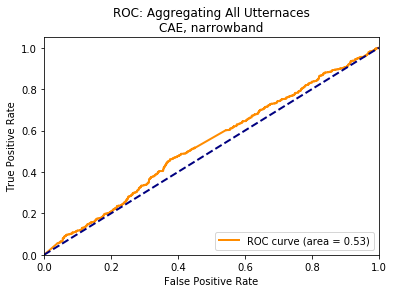

In [13]:
"""
Overall results for independently trained models.
"""
fpr=dict()
tpr=dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(np.array(y_tests[:, i]), np.array(y_scores[:, i]))
    roc_auc[i] = auc(fpr[i], tpr[i])

lw = 2
mgc=1
plt.plot(fpr[mgc], tpr[mgc], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[mgc])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: Aggregating All Utternaces\n'+mod+", "+rep)
plt.legend(loc="lower right")

In [14]:
# fig,ax=plt.subplots(2,3,figsize=(15,8))

# for uItr,utter in enumerate(UTTERS):
#     row_itr=np.mod(uItr,2)
#     col_itr=np.mod(uItr,3)
#     grid=joblib.load(PATH+"/pdSpanish/classResults/svm/params/"+mod+'_'+utter+'_'+rep+'Grid.pkl')
#     pvt = pd.pivot_table(pd.DataFrame(grid.cv_results_),values='mean_test_score', index='param_C',columns='param_gamma')
#     g = sns.heatmap(pvt,ax=ax[row_itr][col_itr])
#     g.set_ylabel("param 'C'")
#     g.set_xlabel("param 'Gamma'")
#     g.set_title('Heatmap: Random Grid Search for SVM params \n'+mod+", "+rep+", "+utter)
#     ylabels = ['{:,.3g}'.format(y) for y in pvt.index]
#     g.set_yticklabels(ylabels)
#     xlabels = ['{:,.3g}'.format(x) for x in pvt.columns]
#     g.set_xticklabels(xlabels)

# plt.tight_layout()

In [ ]:
# UTTERS=['pataka','kakaka','pakata','papapa','petaka','tatata']

# grid=joblib.load(PATH+"/pdSpanish/classResults/svm/params/"+mod+'_'+rep+'aggGrid.pkl')
# print("The best parameters are: %s with a score of %0.2f"
#       % (grid.best_params_, grid.best_score_))

In [ ]:
# grid=joblib.load(PATH+"/pdSpanish/classResults/svm/params/"+mod+'_'+rep+'aggGrid.pkl')
# pvt = pd.pivot_table(pd.DataFrame(grid.cv_results_),values='mean_test_score', index='param_C',columns='param_gamma')
# g = sns.heatmap(pvt)
# g.set_ylabel("param 'C'")
# g.set_xlabel("param 'Gamma'")
# g.set_title('Heatmap: Random Grid Search for SVM params \n'+mod+", "+rep)
# ylabels = ['{:,.3g}'.format(y) for y in pvt.index]
# g.set_yticklabels(ylabels)
# xlabels = ['{:,.3g}'.format(x) for x in pvt.columns]
# g.set_xticklabels(xlabels)
